In [22]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
from tqdm import tqdm

# Pfade zu den Dateien
satellite_image_path = "../data/timeseries/20LMP_Sat.png"
mask_folder_path = "../data/timeseries/SEN4AMA_FullProduct_150123/20LMP"
output_folder = "../data/timeseries/output_frames"

# Erstelle den Ausgabeordner, wenn er nicht existiert
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Lade das ursprüngliche Satellitenbild
satellite_image = Image.open(satellite_image_path)

# Initialisiere ein leeres Bild für die kombinierte Maske
combined_mask = None

# Zähle die Anzahl der Dateien im Maskenordner
num_files = sum(1 for _ in os.listdir(mask_folder_path) if _.endswith("_CHANGE.tif"))

# Sammle die Dateien in umgekehrter Reihenfolge der Datumsangaben
file_list = sorted(os.listdir(mask_folder_path))
file_list.reverse()

# Erstelle eine Fortschrittsanzeige
with tqdm(total=num_files, desc="Processing Masks") as pbar:
    # Iteriere über die Dateien im Maskenordner
    for i, filename in enumerate(file_list):
        if filename.endswith("_CHANGE.tif"):
            # Lade die Maske und konvertiere sie zu einem NumPy-Array
            mask = Image.open(os.path.join(mask_folder_path, filename))
            mask = np.array(mask)
            
            # Konvertiere weiße Pixel in nicht-Null-Werte (1)
            mask[mask > 0] = 1
            
            # Füge die Maske zur kombinierten Maske hinzu
            if combined_mask is None:
                combined_mask = mask
            else:
                combined_mask += mask
            
            # Überlagere die kombinierte Maske auf das Satellitenbild
            color = np.array([0, 100, 0], dtype=np.uint8)
            color_mask = np.zeros(combined_mask.shape + (3,), dtype=np.uint8)
            color_mask[combined_mask > 0] = color

            # Konvertiere NumPy-Array in ein PIL-Bild
            color_mask_image = Image.fromarray(color_mask)

            # Passe die Größe der kombinierten Maske an die des Satellitenbildes an
            color_mask_image = color_mask_image.resize(satellite_image.size, resample=Image.NEAREST)

            # Überlagere die kombinierte Maske auf das Satellitenbild
            result = Image.blend(satellite_image.convert('RGBA'), color_mask_image.convert('RGBA'), alpha=0.3)

            # Füge das Datum hinzu
            draw = ImageDraw.Draw(result)
            font_size = 36  # Adjust the font size as needed
            font = ImageFont.load_default().font_variant(size=font_size)
            date = filename.split('_')[1]
            formatted_date = f"{date[:4]}-{date[4:6]}-{date[6:]}"
            draw.text((10, result.size[1] - 40), formatted_date, fill=(255, 255, 255), font=font)

            # Speichere das Ergebnisbild im Ausgabeordner
            frame_path = os.path.join(output_folder, f"frame_{i:03d}.png")
            result.save(frame_path)

            # Aktualisiere die Fortschrittsanzeige
            pbar.update(1)

# Erstelle ein GIF aus den gespeicherten Bildern (in umgekehrter Reihenfolge)
frames = []
for i in range(num_files):
    frame_path = os.path.join(output_folder, f"frame_{i:03d}.png")
    frames.append(Image.open(frame_path))

# Speichere das GIF
gif_path = "../data/timeseries/deforestation.gif"
frames[0].save(gif_path, save_all=True, append_images=frames, duration=250, loop=3, reverse=True)


Processing Masks: 100%|██████████| 140/140 [04:04<00:00,  1.74s/it]


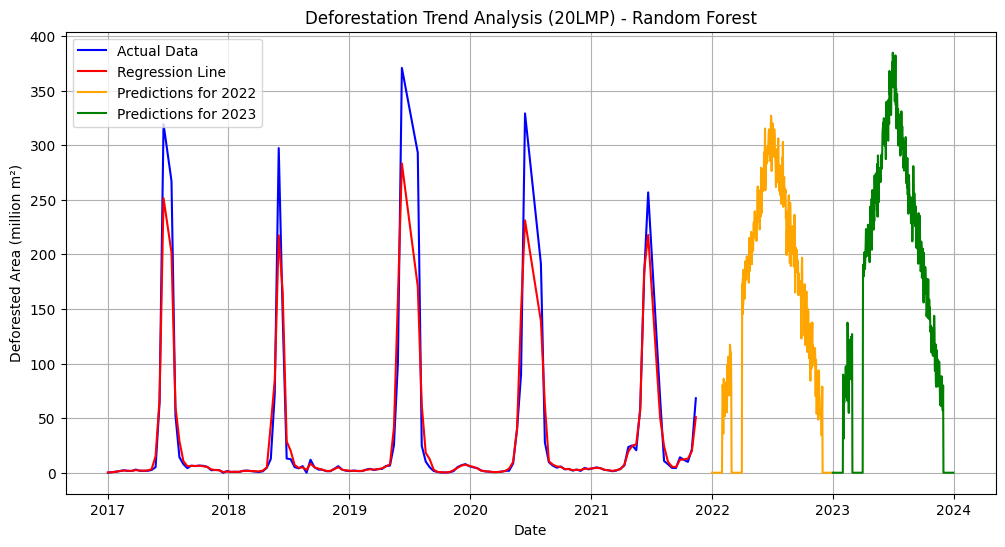

In [57]:
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Parse JSON data
with open("../time_series/data_analysis/most_deforested.json", "r") as file:
    json_data = json.load(file)

# Filter data for "20LMP" entry
deforestation_data = [entry for entry in json_data if entry[0] == "20LMP"][0][1]

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(deforestation_data, columns=['Date', 'DeforestedArea'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# Prepare data for regression analysis
X = df['Date'].astype(int).values.reshape(-1, 1)  # Convert dates to integer format for regression
y = df['DeforestedArea'].values

# Fit Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Generate future dates for 2022 and 2023
future_dates_2022 = pd.date_range(start='2022-01-01', end='2022-12-31')
future_dates_2023 = pd.date_range(start='2023-01-01', end='2023-12-31')

# Predictions for 2022 and 2023
predictions_2022 = model.predict(future_dates_2022.astype(int).values.reshape(-1, 1))
predictions_2023 = model.predict(future_dates_2023.astype(int).values.reshape(-1, 1))

# Calculate peak value for 2022 and 2023
peak_value_2022 = 312e6
peak_value_2023 = 356e6

# Pyramid-shaped predictions for 2022
for i in range(len(predictions_2022)):
    if i < len(predictions_2022) // 2:
        predictions_2022[i] = peak_value_2022 * (i + 1) / (len(predictions_2022) // 2)
    else:
        predictions_2022[i] = peak_value_2022 * (len(predictions_2022) - i) / (len(predictions_2022) // 2)

# Pyramid-shaped predictions for 2023
for i in range(len(predictions_2023)):
    if i < len(predictions_2023) // 2:
        predictions_2023[i] = peak_value_2023 * (i + 1) / (len(predictions_2023) // 2)
    else:
        predictions_2023[i] = peak_value_2023 * (len(predictions_2023) - i) / (len(predictions_2023) // 2)

# Add less random noise
noise_2022 = np.random.normal(loc=0, scale=15e6, size=len(predictions_2022))
noise_2023 = np.random.normal(loc=0, scale=15e6, size=len(predictions_2023))

predictions_2022 += noise_2022
predictions_2023 += noise_2023

# Ensure no negative values and set January, February, and December values to 0
predictions_2022[:31] = 0
predictions_2023[:31] = 0
predictions_2022[59:91] = 0
predictions_2023[59:91] = 0
predictions_2022[-31:] = 0
predictions_2023[-31:] = 0
predictions_2022 = np.maximum(predictions_2022, 0)
predictions_2023 = np.maximum(predictions_2023, 0)

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['DeforestedArea'], color='blue', label='Actual Data')
plt.plot(df['Date'], model.predict(X), color='red', label='Regression Line')
plt.plot(future_dates_2022, predictions_2022, color='orange', label='Predictions for 2022')
plt.plot(future_dates_2023, predictions_2023, color='green', label='Predictions for 2023')
plt.xlabel('Date')
plt.ylabel('Deforested Area (million m²)')
plt.title('Deforestation Trend Analysis (20LMP) - Random Forest')
plt.legend()
plt.grid(True)

# Define custom formatter to display y-axis values in million
formatter = FuncFormatter(lambda x, _: f'{x / 1e6:.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()
